In [131]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as plt

import stretchablecorr as sc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
cube, image_names = sc.load_image_sequence('./images/HS2_01/')

Load images from ./images/HS2_01/...
Image sequence:
 24 frames , 1392*1024 pixels , memory size: 261 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  60p000278.TIF


grid size: 25x16
 i.e. 400 points


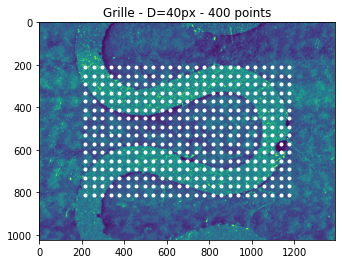

In [36]:
# ==================
#  Define the grid
# ==================

grid_spacing = 40 
grid_margin = 200
# ----
grid = sc.build_grid(cube.shape[1:], margin=grid_margin, spacing=grid_spacing)
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

# Graph the grid
plt.figure();
plt.title(f'Grille - D={grid_spacing}px - {points.shape[0]} points');
sc.plot_grid_points(grid, background=cube[0],
                    color='white', markersize=3)

In [37]:
def _triangulate_xy(I, J, K, xy, params):
    
    u_ij, err_ij = sc.get_shifts(I, J, *xy, **params)

    xy_j = xy + u_ij
    u_jk, err_jk = sc.get_shifts(J, K, *xy_j, **params)
    x_ijk = xy_j + u_jk

    u_ik, err_ik = sc.get_shifts(I, K, *xy, **params)
    x_ik = xy + u_ik

    triangle_error = np.sqrt(np.sum((x_ik - x_ijk)**2))
    max_displ = max(np.sqrt(np.sum(u_ij**2)),
                    np.sqrt(np.sum(u_jk**2)),
                    np.sqrt(np.sum(u_ik**2)))
    # estimated_errors = max(err_ij[1], err_ik[1], err_ik[1])
    estimated_errors = max(err_ij[0], err_ik[0], err_ik[0]) 
    return triangle_error, max_displ, estimated_errors


def triangulate(I, J, K, points, params):
    triangle_errors = []
    estimated_errors = []
    distances = []
    for xy in points:
        try:
            triangl_err, max_displ, estim_err = _triangulate_xy(I, J, K, xy, params)
            triangle_errors.append(triangl_err)
            estimated_errors.append(estim_err)
        except ValueError:
            triangle_errors.append(np.NaN)
            estimated_errors.append(np.NaN)
        
    return np.array(triangle_errors), estimated_errors


def construct_key(p):
    name = f"{p['window_half_size']}px"
    if p['coarse_search']:
        name += ' coarse'
    if p['phase']:
        name += ' phase'
    else:
        name += ' CC'
    name += ' ' + p['method']
    return name

In [106]:
# test
ijk = 19, 20, 21
#ijk = 4, 6, 8
IJK = [cube[idx] for idx in ijk]
params = {'window_half_size': 25,
          'coarse_search': True,
          'phase': False,
          'method':'opti' }
triangle_errors, estimated_errors  = triangulate(*IJK, points, params)

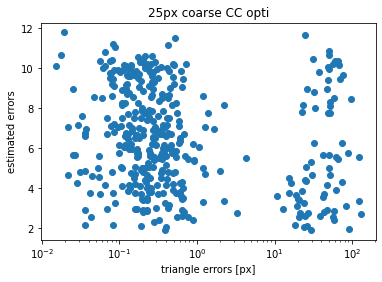

In [107]:
plt.semilogx(triangle_errors, estimated_errors, 'o')
plt.title(construct_key(params)); plt.xlabel('triangle errors [px]')
plt.ylabel('estimated errors');

In [108]:
argsorted = np.argsort(triangle_errors)[::-1]

In [110]:
pts = argsorted[3]
print(pts, points[pts])

385 [616 812]


In [111]:
params = {'window_half_size': 35,
          'coarse_search': True,
          'phase':False,
          'method':'opti' }
_triangulate_xy(*IJK, points[pts], params)

(73.9698296089574, 68.71597784361953, 10.250922434465204)

[-8.83893507 27.63787209]
[-4.73950032 14.69199384]
[-13.42285075  40.62809193]
triangle_error 1.7088713550777044
triangle_error 1.708871355077684


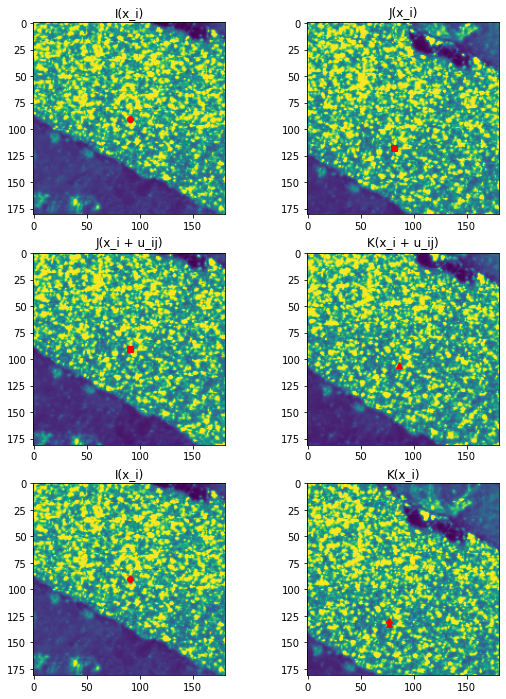

In [118]:
ijk = 19, 20, 21
#ijk = 4, 6, 8
IJK = [cube[idx] for idx in ijk]

window_half_size = 90
params = {'window_half_size': window_half_size,
          'coarse_search': False,
          'phase':False,
          'method':'opti' }

I, J, K = IJK
xy_i = points[pts]

u_ij, err_ij = sc.get_shifts(I, J, *xy_i, **params)
print(u_ij)

xy_j = xy_i + u_ij
u_jk, err_jk = sc.get_shifts(J, K, *xy_j, **params)
x_ijk = xy_j + u_jk
print(u_jk)

u_ik, err_ik = sc.get_shifts(I, K, *xy_i, **params)
x_ik = xy_i + u_ik
C, ij = sc.crop(K, xy_i, window_half_size)
print(u_ik)


fig, axes = plt.subplots(3, 2, figsize=(9,12))

A0, ij = sc.crop(I, xy_i, window_half_size)
B0, ij = sc.crop(J, xy_i, window_half_size)
C0, ij = sc.crop(K, xy_i, window_half_size)

a0 = np.array(A0.shape)/2
b0 = a0 + u_ij[::-1]
c0 = a0 + u_jk[::-1]
c1 = a0 + u_ik[::-1]
c2 = a0 + u_ij[::-1] + u_jk[::-1]

ax1 = axes[0, 0]
ax1.imshow(A0); ax1.plot(*a0[::-1], 'or'); ax1.set_title('I(x_i)');

ax2 = axes[0, 1]
ax2.imshow(B0); ax2.plot(*b0[::-1], 'sr'); ax2.set_title('J(x_i)');

B1, ij = sc.crop(J, xy_j, window_half_size)
C1, ij = sc.crop(K, xy_j, window_half_size)
ax3 = axes[1, 0]
ax3.imshow(B1); ax3.plot(*a0[::-1], 'sr'); ax3.set_title('J(x_i + u_ij)');

ax4 = axes[1, 1]
ax4.imshow(C1); ax4.plot(*c0[::-1], '^r'); ax4.set_title('K(x_i + u_ij)');

ax5 = axes[2, 0]
ax5.imshow(A0); ax5.plot(*a0[::-1], 'or'); ax5.set_title('I(x_i)');

ax6 = axes[2, 1]
ax6.imshow(C0); ax6.plot(*c1[::-1], 'dr'); ax6.set_title('K(x_i)');
ax6.plot(*c2[::-1], '^r');

print('triangle_error', np.sqrt(np.sum((x_ik - x_ijk)**2)))
print('triangle_error', np.sqrt(np.sum((u_ij + u_jk - u_ik)**2)))

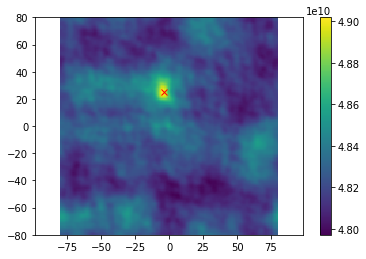

In [78]:
dx_span, dy_span, phase_corr, res = sc.output_cross_correlation(A0, C0, upsamplefactor=1, phase=False)

argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]

plt.pcolor(dx_span, dy_span, phase_corr)
plt.plot(*argmax[::-1], 'xr'); plt.colorbar();
plt.axis('equal');
#plt.xlim([-10, 10]);
#plt.ylim([-10, 14]);

In [121]:
def two_steps_tracker(I, J, K, x_i, params):
    
    # i -> j
    u_ij, err_ij = sc.get_shifts(I, J, *x_i, **params)

    # j -> k
    x_ij = x_i + u_ij
    u_jk, err_jk = sc.get_shifts(J, K, *x_j, **params)
    x_ijk = x_j + u_jk

    # i -> k
    u_ik, err_ik = sc.get_shifts(I, K, *x_i, **params)
    x_ik = x_i + u_ik

    triangle_error = np.sqrt(np.sum((x_ik - x_ijk)**2))
    
    x_j_avg = (x_ij + 0.5*(x_ik-u_jk))/1.5
    
    return x_j_avg, triangle_error

In [127]:
points[pts]

array([616, 812])

In [128]:
sc.track_displ_img_to_img?

Signature:
sc.track_displ_img_to_img(
    images,
    start_points,
    offsets=None,
    verbose=True,
    **params,
)
Docstring: <no docstring>
File:      ~/jupyter/stretchablecorr/stretchablecorr/stretchablecorr.py
Type:      function


In [144]:
points[1, None]

array([[256, 212]])

In [148]:
sc.track_displ_img_to_img(cube, points[1, None], window_half_size=15, method='opti')

done                               


(array([[[-3.99974706e-01, -1.18988738e+00]],
 
        [[-5.62561728e-01, -4.81088724e-01]],
 
        [[ 1.74844527e-02, -2.51503461e-02]],
 
        [[-6.66523274e-01, -3.67523942e-01]],
 
        [[ 4.59634404e-01,  3.22770223e-02]],
 
        [[-5.92211018e-02,  8.29189241e-02]],
 
        [[-1.23061716e-01,  3.74155326e-02]],
 
        [[-5.14133848e-02,  3.95993485e-03]],
 
        [[ 1.64346918e-01, -9.71219903e-01]],
 
        [[ 3.27625431e-01, -4.19626989e-02]],
 
        [[ 2.55645647e-02, -5.70104017e-01]],
 
        [[ 1.41524751e-01, -1.57819915e-01]],
 
        [[ 9.69127485e-01, -2.10875135e+00]],
 
        [[ 5.23739921e-01, -2.03278994e+00]],
 
        [[ 3.69673804e-01, -1.96428053e+00]],
 
        [[ 2.16698255e+00, -7.39915002e+00]],
 
        [[ 9.55269746e-01, -5.80458796e+00]],
 
        [[ 8.32045107e-01, -1.18601290e+01]],
 
        [[-1.04814580e+00, -5.11526233e+00]],
 
        [[-2.86006430e+00, -3.21034492e+00]],
 
        [[-1.83802849e+00, -2.18202187e+

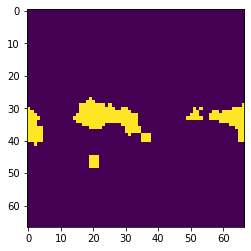

In [365]:
plt.imshow(phase_corr > np.min(phase_corr) + np.ptp(phase_corr)*0.8)

In [348]:
displ, err = sc.get_shifts(A, B, *np.array(A.shape)/2,
           window_half_size=A.shape[0]//2-1,
           coarse_search=False,
           phase=False,
           method='opti')
print(displ, err)

[ 4.67406666 10.16816915] [8.75972393765493, 1.9823060229753033]


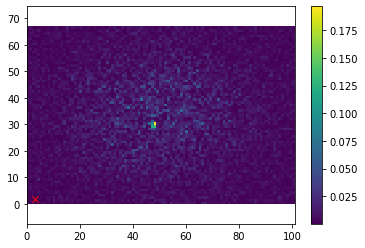

In [303]:
plt.pcolor(phase_corr);
plt.plot(*(-np.array(res)), 'rx')
plt.colorbar(); plt.axis('equal');

[ 12.81097789 -12.98070707] (-2.0, -2.0)


TypeError: Dimensions of C (101, 67) are incompatible with X (101) and/or Y (67); see help(pcolor)

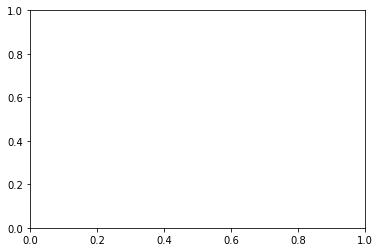

In [297]:
print(displ,res)
plt.figure();
plt.pcolor(dx_span, dy_span, phase_corr.T);
plt.plot(*(-np.array(res)), 'rx')
plt.colorbar(); plt.axis('equal');

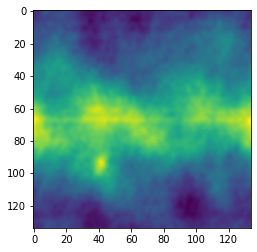

In [293]:
argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)

plt.imshow(phase_corr.T)
plt.plot(*argmax_idx, 'ow'); plt.colorbar();

In [286]:
phase_corr[argmax_idx]

7965020257.0

In [ ]:
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]

In [248]:
from scipy.ndimage import convolve, correlate

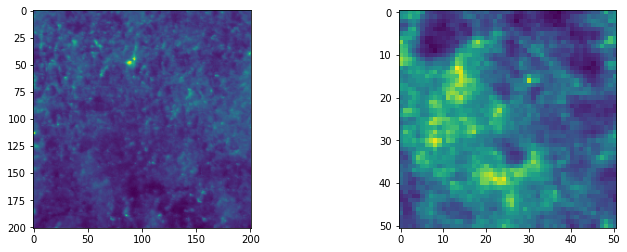

In [258]:
window_half_size = 100
A, ij = sc.crop(I, points[pts], window_half_size)
B, ij = sc.crop(J, points[pts], window_half_size//4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);

In [259]:
%%timeit
CC = correlate(A, B)

162 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


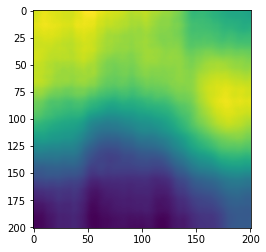

In [260]:
plt.imshow(CC)

In [143]:
results = {}
ijk = 0, 2, 4
#ijk = 17, 18, 19
IJK = [cube[idx] for idx in ijk]

coarse_search = True
params = {'window_half_size': 40,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)


params = {'window_half_size': 20,
          'coarse_search':coarse_search,
          'phase': True,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 40,
          'coarse_search':coarse_search,
          'phase': True,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 7,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

In [144]:
from tabulate import tabulate

In [146]:
table_data = [{'params':k,
               'count':len(row[0]),
               'mean err':np.mean(row[0]),
               'max err':np.max(row[0])} for k, row in results.items()]

In [148]:
print( tabulate(table_data, headers='keys') )

params                    count    mean err    max err
----------------------  -------  ----------  ---------
40px coarse CC opti         108   0.0928087   0.409791
15px coarse CC opti         108   0.12788     0.928883
20px coarse phase opti      108   0.201445    1.67567
40px coarse phase opti      108   0.149938    0.625801
7px coarse CC opti          108   0.171704    0.970679


In [8]:
sorted_results = sorted(list(results.items()), key=lambda x:np.mean(x[1][0]))

print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

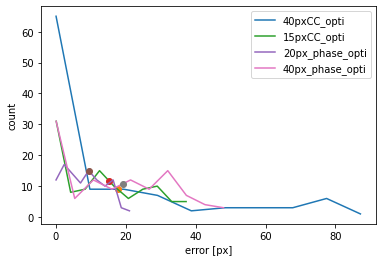

In [90]:
for key, (errors, distances) in results.items():
    d_mean = np.mean(errors)
    n, bins = np.histogram(errors);
    plt.plot(bins[:-1], n, label=key)
    
    plt.plot(d_mean, np.interp(d_mean, bins[:-1], n), 'o')

plt.legend(); plt.xlabel('error [px]')
plt.ylabel('count');

In [104]:
print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

15px_coarseCC_opti     13.92 29.910678116130637
40px_coarseCC_opti     14.69 32.93321053611752
40px_coarse_phase_opti   14.77 31.255842745998883
20px_coarse_phase_opti   16.15 30.535217185822052


In [88]:
print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0])}'
       for k in sorted_results]))

40pxCC_opti          0.13291181977007294
40px_phase_opti      0.1499698289412096
15pxCC_opti          0.18231776868004598
20px_phase_opti      0.28273282830294405


In [68]:
plt.imshow(distances_grid);
plt.colorbar();

NameError: name 'distances_grid' is not defined

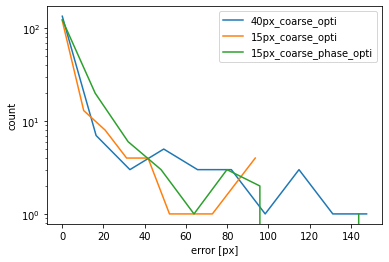

In [45]:
results = {}
ijk = 17, 18, 19
IJK = [cube[idx] for idx in ijk]

params = {'window_half_size': 40,
          'coarse_search':True,
          'phase': False,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':True,
          'phase': False,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':True,
          'phase': True,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

for key, distances in results.items():
    n, bins = np.histogram(distances);
    plt.semilogy(bins[:-1], n, label=key)
    
plt.legend(); plt.xlabel('error [px]')
plt.ylabel('count');

## windows size choice

In [34]:
results = {}
#ijk = 17, 18, 19
ijk = 0, 8, 16
IJK = [cube[idx] for idx in ijk]

windows_size_span = [5, 10, 15, 20, 30, 40, 60, 80]

coarse_search = True
for whs in windows_size_span:
    print(whs)
    params = {'window_half_size': whs,
              'coarse_search':coarse_search,
              'phase': False,
              'method':'opti' }
    results[construct_key(params)] = triangulate(*IJK, points, params)

5
10
15
20
30
40
60
80


In [35]:
sorted_results = sorted(list(results.items()), key=lambda x:np.mean(x[1][0]))

print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

30px_coarse_CC_opti     3.72 28.56224737617137
80px_coarse_CC_opti     4.48 23.69392857047381
15px_coarse_CC_opti     4.64 28.369004734935906
20px_coarse_CC_opti     4.91 27.874181485847988
10px_coarse_CC_opti     5.10 28.519422863760852
40px_coarse_CC_opti     5.13 29.05337778831928
60px_coarse_CC_opti     5.14 28.499171364393945
5px_coarse_CC_opti      5.97 27.465819493463


ijk = 0, 2, 4

    40px_coarse_CC_opti     0.09 2.259973140522304
    30px_coarse_CC_opti     0.10 2.2622871765443
    20px_coarse_CC_opti     0.12 2.261829636143824
    15px_coarse_CC_opti     0.13 2.2634306646659104
    10px_coarse_CC_opti     0.14 2.26663557199468
    5px_coarse_CC_opti      0.27 2.298498600568171

    40px_coarse_phase_opti    0.15 2.2654455306205796
    30px_coarse_phase_opti    0.16 2.264311597123281
    20px_coarse_phase_opti    0.20 2.3456869633174007
    15px_coarse_phase_opti    0.21 2.3517071681117967
    10px_coarse_phase_opti    0.31 2.389567565122548
    5px_coarse_phase_opti    0.58 2.3683886448966254


ijk = 17, 18, 19

    20px_coarse_CC_opti    12.61 31.070749300731286
    10px_coarse_CC_opti    13.57 29.295575670259872
    30px_coarse_CC_opti    13.62 31.880018045480217
    15px_coarse_CC_opti    13.92 29.910678115302705
    40px_coarse_CC_opti    14.69 32.93321053537991
    5px_coarse_CC_opti     16.87 29.68630756901744


    5px_coarse_phase_opti   13.49 27.914897056628146
    40px_coarse_phase_opti   14.77 31.255842745998883
    10px_coarse_phase_opti   14.87 28.596095838056392
    30px_coarse_phase_opti   15.20 30.92854706730653
    20px_coarse_phase_opti   16.15 30.535217185822052
    15px_coarse_phase_opti   16.28 30.15249085909452


In [26]:
sc.output_cross_correlation()

{'5px_coarse_phase_opti': (array([0.15605253, 3.43746451, 1.31822246, 0.12025068, 0.15166513,
         0.20313105, 0.19375451, 0.12767603, 0.51301288, 0.13303454,
         2.90647874, 0.25624548, 0.11577166, 0.23919705, 0.56016769,
         0.65833142, 2.76731786, 0.06869799, 0.17444817, 0.10676588,
         0.15381765, 0.30667947, 0.9436287 , 1.04431852, 0.03801057,
         2.01249974, 0.04713827, 2.32732379, 1.02447077, 0.06564012,
         0.27462757, 0.14303113, 0.14962942, 0.04647105, 0.39569453,
         1.6442606 , 0.83942252, 0.51178693, 0.09222676, 0.32942204,
         1.13096865, 0.13294132, 0.09946304, 0.42150253, 0.6220116 ,
         0.14762309, 0.10044892, 0.24953748, 0.11288377, 0.4133627 ,
         1.77087102, 0.17255768, 0.06103048, 0.06459148, 0.25978686,
         1.70429931, 1.00579342, 0.33426853, 0.13628123, 0.77822778,
         0.2753024 , 0.33918378, 0.09063071, 0.20089951, 0.26432658,
         0.64382433, 3.91104762, 0.20140142, 0.2028203 , 0.06289126,
         